In [1]:
# The necessary imports
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
plt.ion()

In [2]:
# Load Data / 이미지 augmentation 및 정규화
# validation을 위한 정규화 (Test set)
# 추후에 쓰일 모델인 ImageNet에서 미리 학습된(Pre-trained) Resnet18 모델을 위한
# Image의 정규화 값 및 표준편차 값 설정 (224x224 / [0.485, 0.456, 0.406])
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
# torchvision, torch.utils.data 패키지 사용해 데이터 load
data_dir = '..\\Caps'
# loading datasets with PyTorch ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [4]:
dataset_sizes
# no validation? => test set에서 loss 및 acc 최신화하는 것과 validation set 구분하여 
# 학습하는 것과 큰 차이가 없었음

{'train': 5994, 'test': 5794}

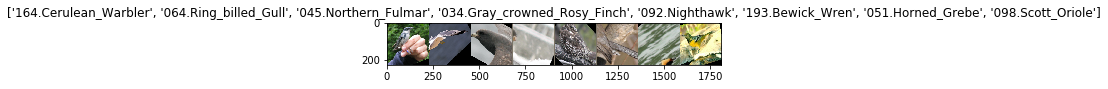

In [5]:
# Visualize some training images for understanding data augmentations
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
# 모델 학습 함수 정의, 학습결과 재사용을 위한 checkpoint 저장 포함
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data ####################변경점
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model_ft.state_dict(),'optim':optimizer_ft.state_dict()}
                torch.save(state,'..\\Caps\\checkp\\point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
# 모델 시각화 함수 정의
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()
    

    for i, data in enumerate(dataloders['test']):
        inputs, labels = data
        #print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        #print(outputs)
        _, preds = torch.max(outputs.data, 1)
        #print(preds)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [8]:
# Resnet18모델 load / conv.netword layer 최종 설정
model_ft = models.resnet18(pretrained=True) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)      # changing the last layer for this dataset by setting last layer neurons to 200 as this dataset has 200 categories
 
if use_gpu:                                 # if gpu is available then use it
    model_ft = model_ft.cuda()       

criterion = nn.CrossEntropyLoss()           # defining loss function

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft,num_epochs=100)
# 과도한 학습 시 overfitting 문제?

Epoch 0/99
----------
train Loss: 0.6687 Acc: 0.0080
test Loss: 0.6468 Acc: 0.0176

Epoch 1/99
----------
train Loss: 0.6426 Acc: 0.0204
test Loss: 0.6144 Acc: 0.0492

Epoch 2/99
----------
train Loss: 0.6175 Acc: 0.0502
test Loss: 0.5726 Acc: 0.1113

Epoch 3/99
----------
train Loss: 0.5871 Acc: 0.0969
test Loss: 0.5220 Acc: 0.1795

Epoch 4/99
----------
train Loss: 0.5580 Acc: 0.1328
test Loss: 0.4768 Acc: 0.2259

Epoch 5/99
----------
train Loss: 0.5293 Acc: 0.1700
test Loss: 0.4399 Acc: 0.2784

Epoch 6/99
----------
train Loss: 0.5062 Acc: 0.1997
test Loss: 0.4102 Acc: 0.3298

Epoch 7/99
----------
train Loss: 0.4860 Acc: 0.2321
test Loss: 0.3810 Acc: 0.3642

Epoch 8/99
----------
train Loss: 0.4669 Acc: 0.2653
test Loss: 0.3588 Acc: 0.4032

Epoch 9/99
----------
train Loss: 0.4496 Acc: 0.2866
test Loss: 0.3406 Acc: 0.4289

Epoch 10/99
----------
train Loss: 0.4340 Acc: 0.3103
test Loss: 0.3229 Acc: 0.4411

Epoch 11/99
----------
train Loss: 0.4198 Acc: 0.3262
test Loss: 0.3044 Acc

test Loss: 0.1106 Acc: 0.7603

Epoch 97/99
----------
train Loss: 0.1447 Acc: 0.7372
test Loss: 0.1089 Acc: 0.7603

Epoch 98/99
----------
train Loss: 0.1422 Acc: 0.7381
test Loss: 0.1098 Acc: 0.7575

Epoch 99/99
----------
train Loss: 0.1400 Acc: 0.7456
test Loss: 0.1076 Acc: 0.7596

Training complete in 53m 41s
Best test Acc: 0.763721


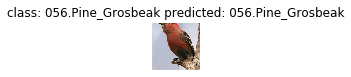

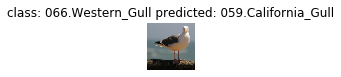

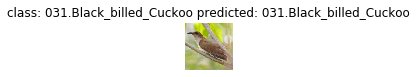

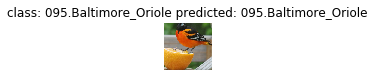

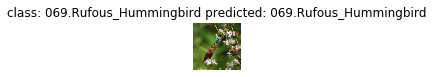

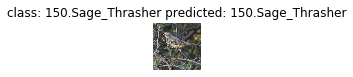

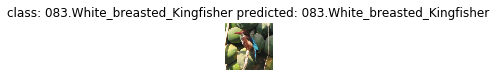

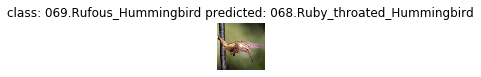

In [10]:
visualize_model(model_ft)
# 몇몇 모델 예측 결과 시각화

In [11]:
# Acc top 1-5
class AverageMeter(object):
    # Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
def accuracy(output, target, topk=(1,)):
   # Computes the precision@k for the specified values of k
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [13]:
def calc_accuracy(model, data):
    model.eval()
    if use_gpu:
      model.cuda()    
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloders[data]):
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        prec1, prec5 = accuracy(outputs, Variable(labels), topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5

In [14]:
top1 ,top5 = calc_accuracy(model_ft, 'test')

In [15]:
top1.avg

tensor(75.9579, device='cuda:0')

In [16]:
top5.avg

tensor(94.4080, device='cuda:0')

In [17]:
def process_image(image_path):
    # Scales, crops, and normalizes a PIL image for a PyTorch
    # model, returns an Numpy array
    
    # Open the image(PIL)
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std # 각 색상 채널에서 평균을 뺀 다음 표준 편차로 나눔
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [18]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensor와 다르게, matplotlib에서는 세 번째 차원으로 가정함(Pytorch 텐서는 첫 번째)
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [19]:
# Class Prediction
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy to Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(Variable(model_input.cuda())))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs, top_labs =top_probs.data, top_labs.data
    top_probs = top_probs.cpu().numpy().tolist()[0] 
    top_labs = top_labs.cpu().numpy().tolist()[0]
    
    top_birds = [class_names[lab] for lab in top_labs]
    return top_probs, top_birds

In [20]:
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    title_ = image_path.split('/')[2]
    
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    probs, birds = predict(image_path, model) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=birds, color=sns.color_palette()[0]);
    plt.show()

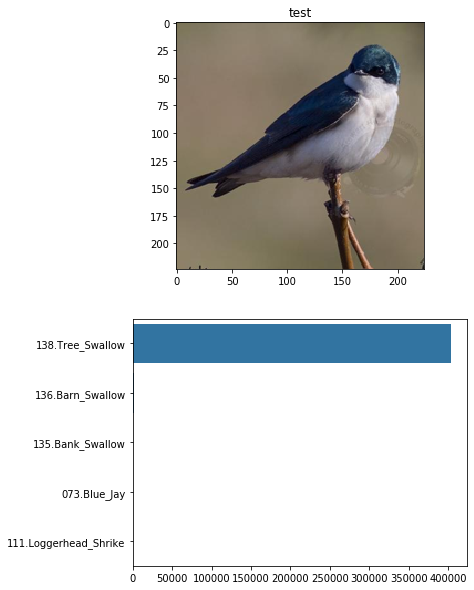

In [25]:
image_path = '../Caps/test/138.Tree_Swallow/Tree_Swallow_0108_135068.jpg'
plot_solution(image_path, model_ft)

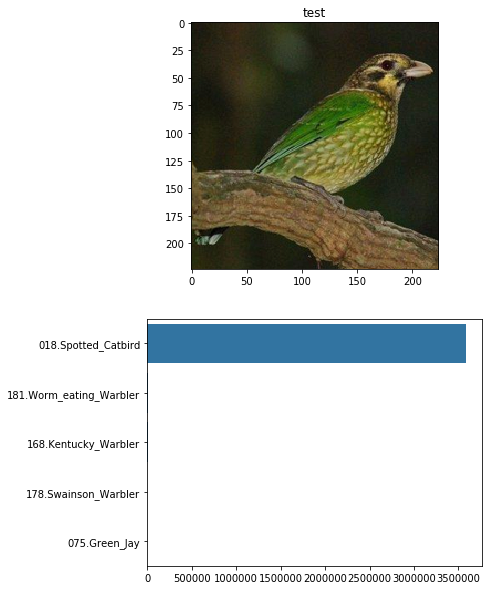

In [22]:
image_path = '../Caps/test/018.Spotted_Catbird/Spotted_Catbird_0026_796818.jpg'
plot_solution(image_path, model_ft)

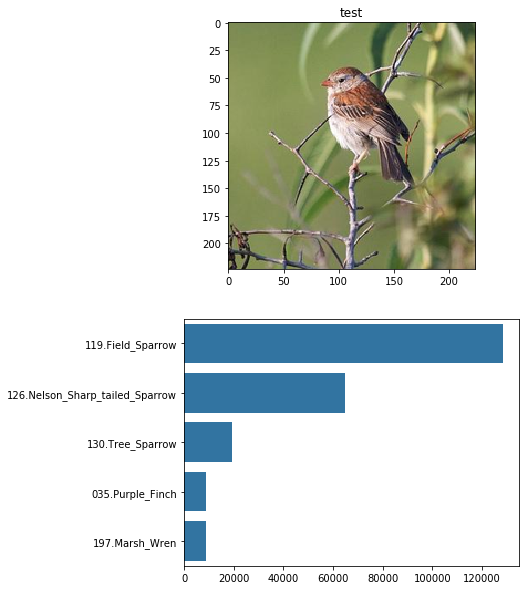

In [31]:
image_path = '../Caps/test/119.Field_Sparrow/Field_Sparrow_0008_113459.jpg'
plot_solution(image_path, model_ft)